# Extraction of CCI Aboveground Biomass via BYOC Collection

In [1]:
import os

# define repo name and get root working directory
repo = 'byoc-api'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]
root_path

'C:\\Users\\crwil\\Documents\\GitHub\\sentinelhub\\byoc-api'

In [2]:
from sentinelhub import (
    SHConfig, DataCollection, Geometry, BBox, CRS,
    SentinelHubRequest, filter_times, bbox_to_dimensions, MimeType,
    SentinelHubBYOC, ByocCollection, ByocTile, ByocCollectionAdditionalData,
    DownloadFailedException
)

# Initialize SentinelHubBYOC class
config = SHConfig()

In [3]:
# get pathname to configuration file
cfg_path = os.path.join( os.path.join( root_path, 'cfg/esa' ) )
cfg_file = os.path.join( cfg_path, 'agb-1.yml' )
with open( cfg_file ) as f:
    print ( f.read() )

request:
    evalscript: |
                //VERSION=3
                function setup() {
                    return {
                        input: [{
                            bands: [ "agb", "agb_sd" ],
                        } ],
                        output: [
                            {id: "AGB", bands: 1, sampleType: SampleType.UINT16},
                            {id: "AGB_SD", bands: 1, sampleType: SampleType.UINT16} ]
                    }
                }
                function evaluatePixel(samples) {                  
                
                    var agb = [ samples.agb ]
                    var agb_sd = [ samples.agb_sd ]
                    return {
                        AGB: agb,
                        AGB_SD: agb_sd
                    }

                
                
                
                    return [ samples.agb ]
                }
    inputs:
        - collection: byoc-d47c698f-d92d-439b-a132-68e735f7888f
responses:
    AGB: TIFF

In [4]:
import yaml
from munch import munchify

# load cfg file using yaml parser
with open( cfg_file, 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [5]:
# setup aoi limits and resolution
coords = 40, -4.5, 41, -3
resolution = 100

In [6]:
# create instance of shclient class
from processapi import Client
client = Client( config )

In [7]:
# get utm bbox
bbox = client.getBoundingBox( coords, src_crs=CRS(4326) )
print ( bbox, bbox.crs.value )

610939.8258718355,9502528.570595685,722292.1692507417,9668203.708321478 32737


In [8]:
# get aoi image dimensions
client.getBoxDimensions( bbox, resolution )

(1114, 1657)

In [9]:
# pick a few dates
from datetime import datetime
timeframe = { 'start' : datetime( 2010, 9, 1, 0, 0, 0 ), 
                'end' : datetime( 2019, 11, 7, 23, 59, 59 ) }
timeframe

{'start': datetime.datetime(2010, 9, 1, 0, 0),
 'end': datetime.datetime(2019, 11, 7, 23, 59, 59)}

In [10]:
# get S1 acquisitions between start / end dates satisfying filter conditions
client.getDatasetTimeStamps( config.request.inputs[ 0 ], bbox, timeframe )

[datetime.datetime(2018, 1, 1, 0, 0, tzinfo=tzutc())]

In [11]:
# get time series
response = client.getTimeSeries ( bbox, timeframe, resolution )
response._df

,AGB.tif,AGB_SD.tif,time
0,"[[0, 0, 35, 39, 46, 48, 48, 48, 47, 51, 53, 34...","[[0, 0, 31, 35, 41, 43, 43, 42, 40, 41, 41, 29...",2018-01-01 00:00:00+00:00


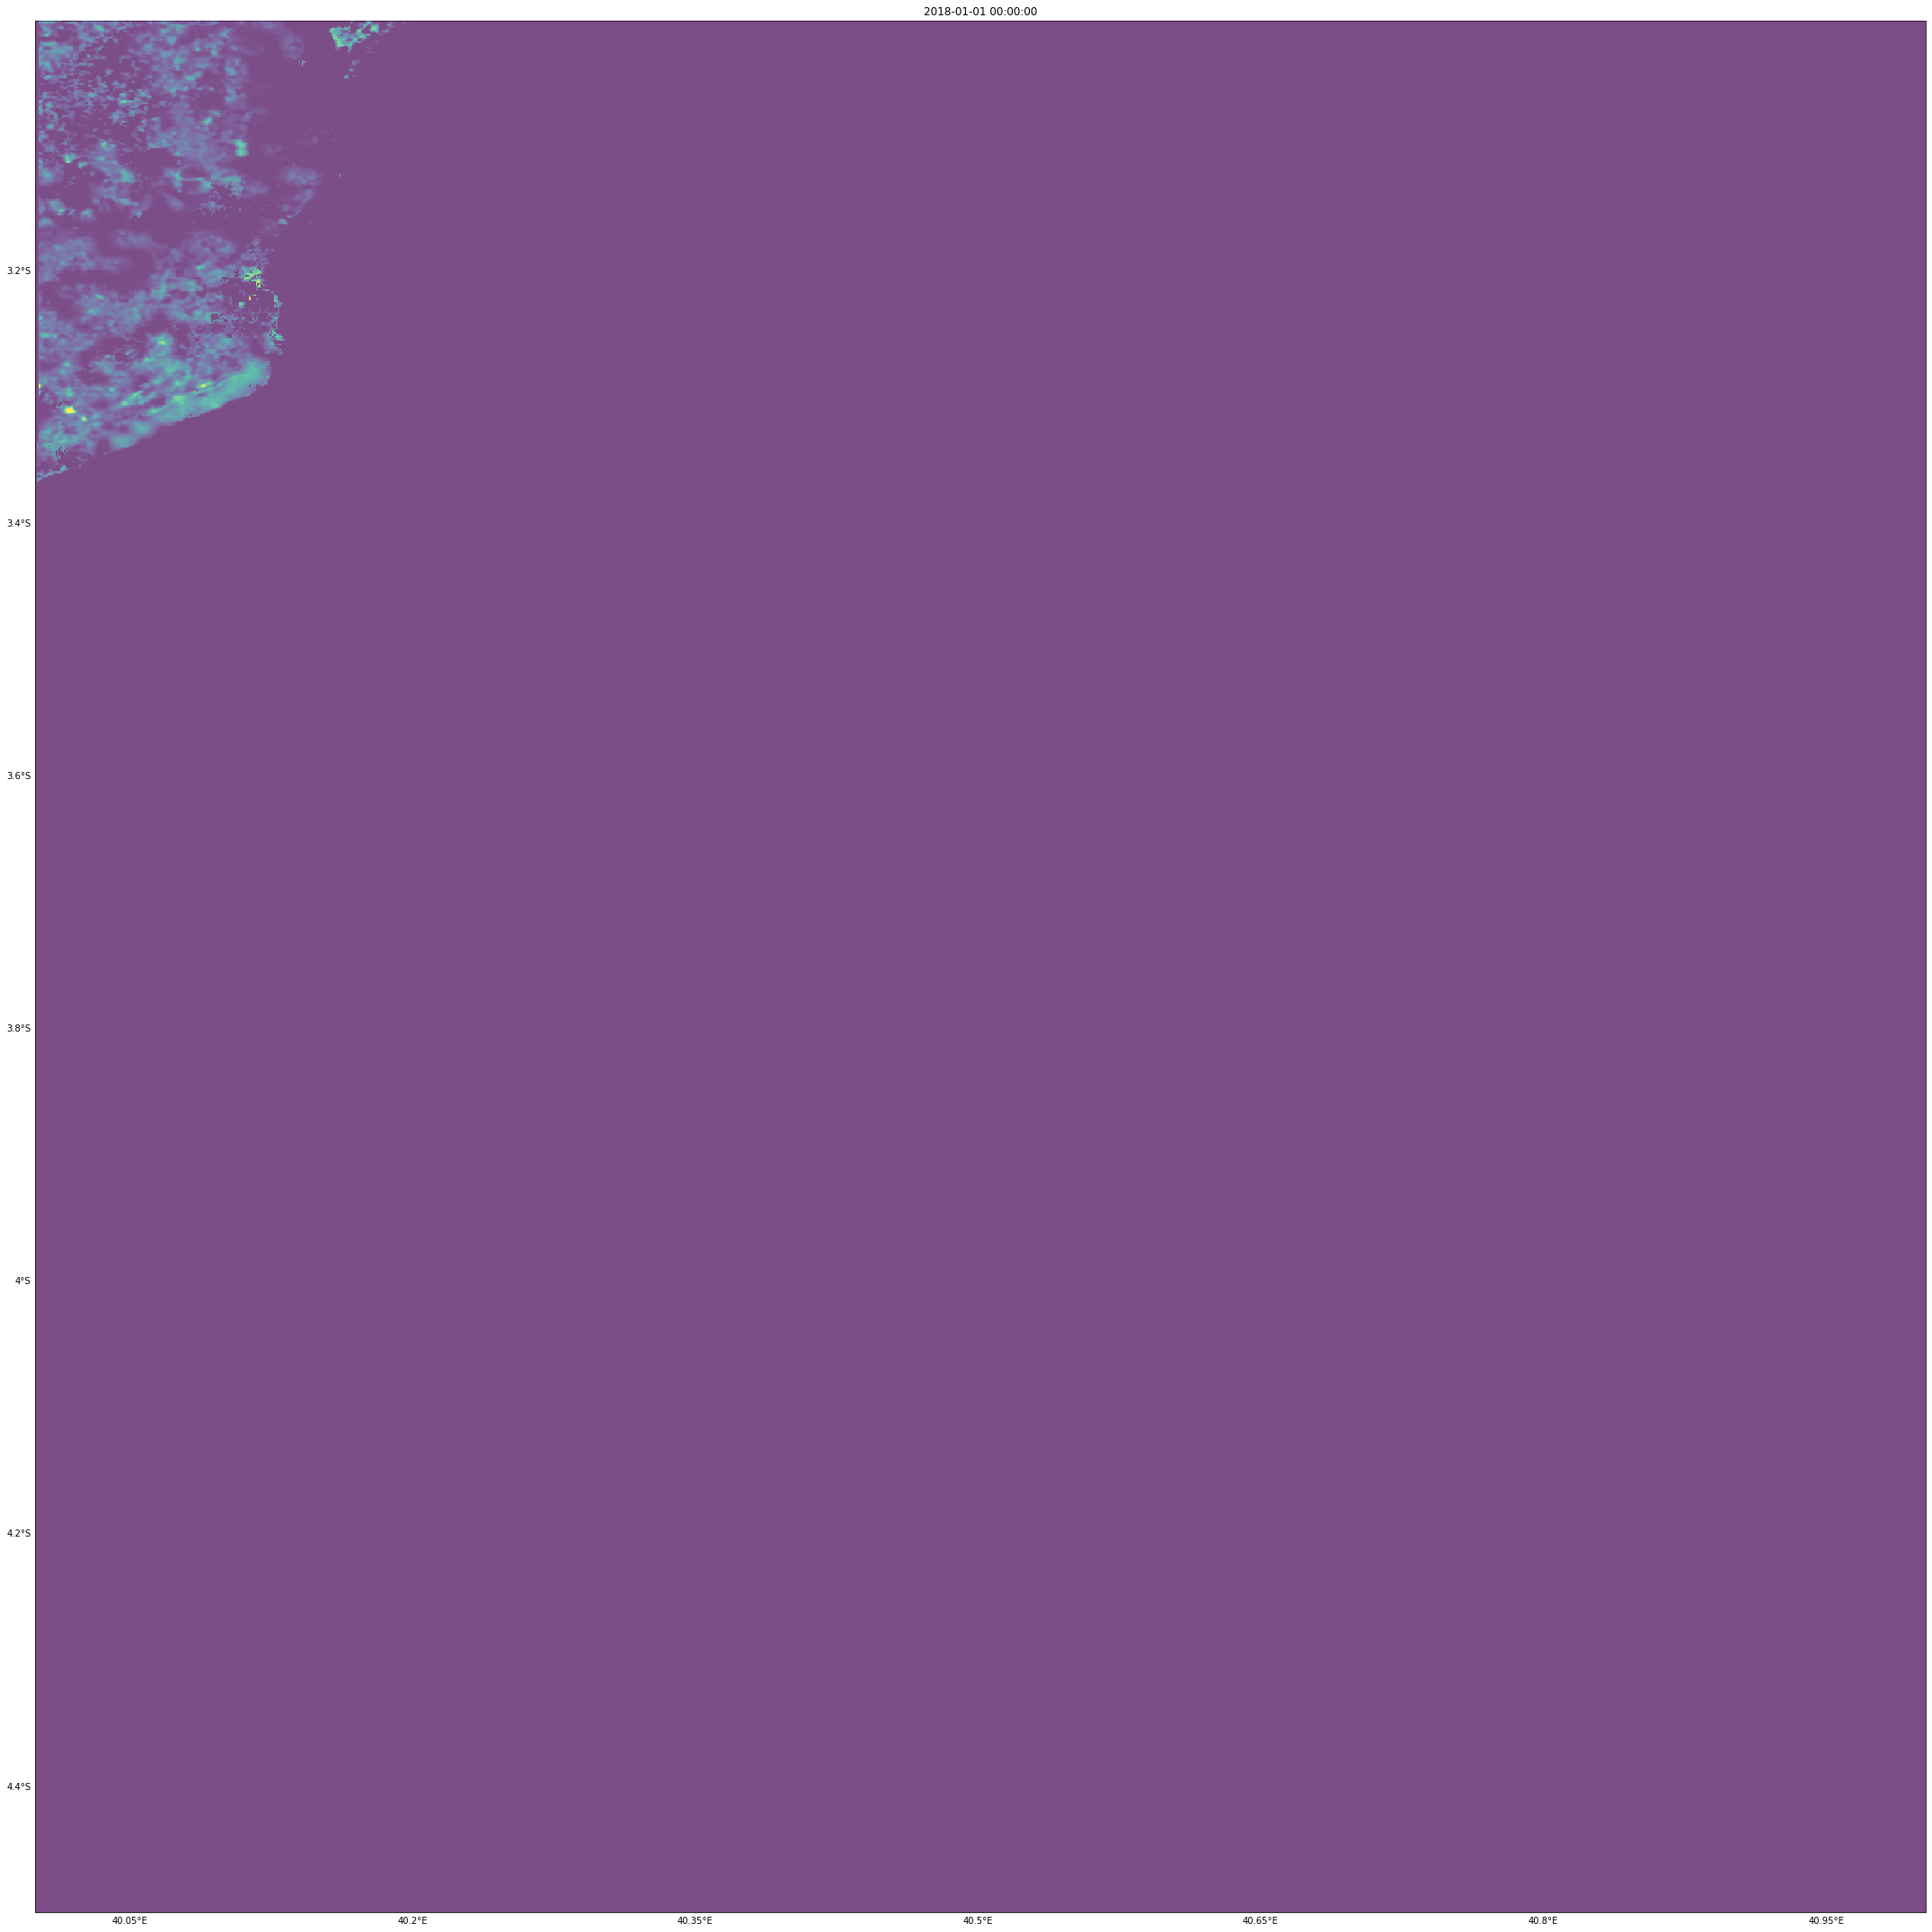

In [12]:
response.plotImages( 'AGB.tif', alpha={ 'data' : 0.7, 'grid' : 0.3 } )